In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2, PauliFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import QSVC, VQC
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.algorithms.optimizers import SPSA, COBYLA
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from IPython.display import clear_output
from utils import *
import time
# %matplotlib inline
encoder = OneHotEncoder()


plt.rcParams['figure.figsize'] = [20, 20]
seed = 10599

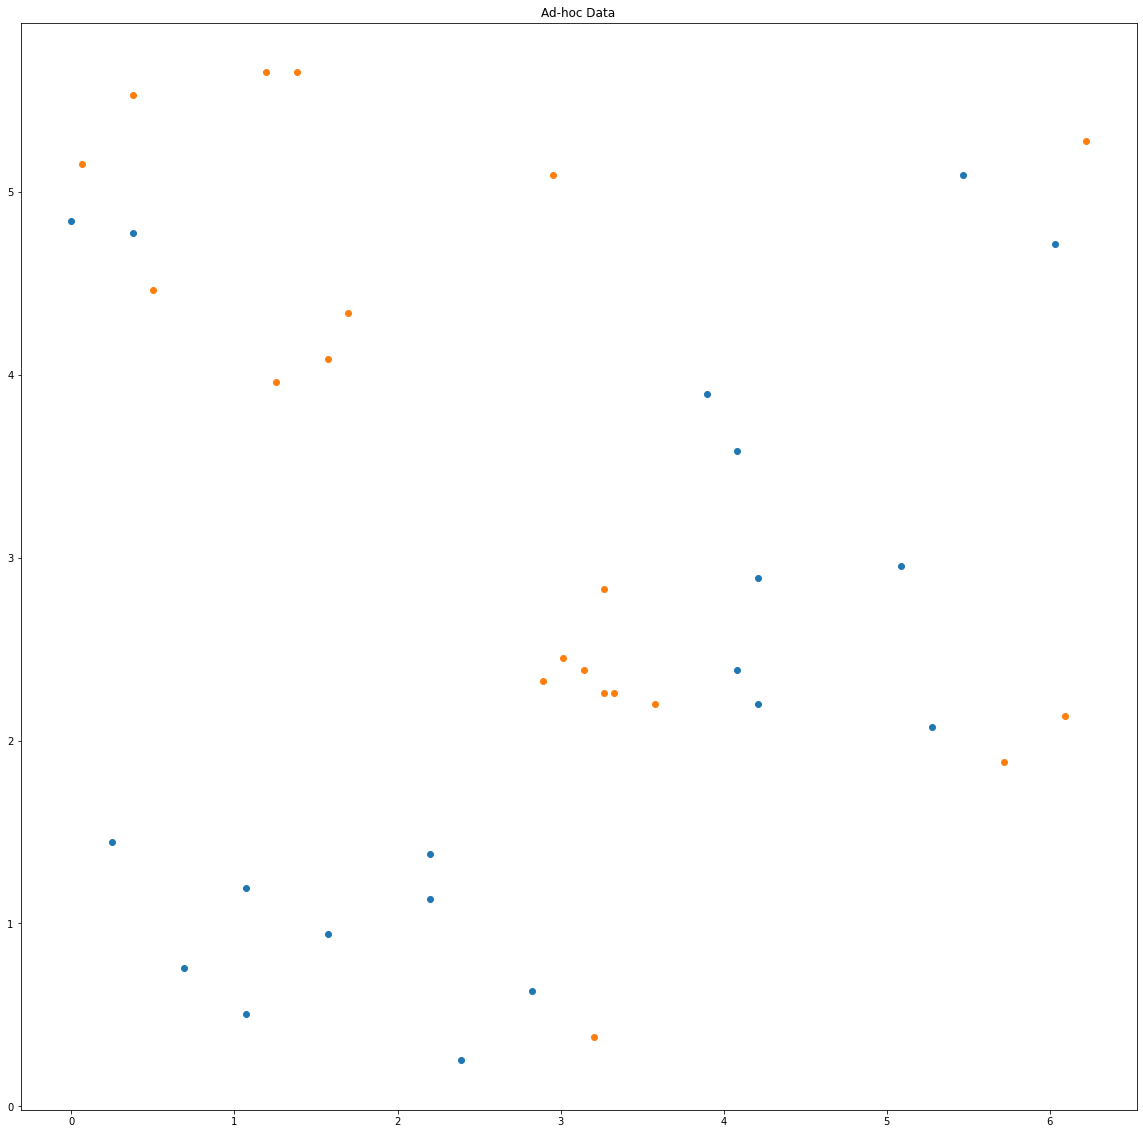

In [2]:
#Ad_hoc_data dataset loading from qiskit
feature_dim = 2
train_data, train_labels, test_data, test_labels = (ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=True
))

In [6]:
#Transforming the labels from list of one-hot-vector to numbers
train_labels_one = [int("".join(str(int(x)) for x in label),2) for label in train_labels]
test_labels_one = [int("".join(str(int(x)) for x in label),2) for label in test_labels]
print(np.array(train_data).shape)
print(np.array(train_labels_one).shape)

(40, 2)
(40,)


In [7]:
backend = AerSimulator()
qinst = QuantumInstance(backend=backend)

In [8]:
#Creating the qsvc instance with a ZZFeatureMap and a quantum kernel
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
kernel = QuantumKernel(feature_map = feature_map, quantum_instance=qinst)
qsvc = QSVC(quantum_kernel=kernel, verbose = True)
qsvc.fit(train_data,train_labels_one)
qsvc.score(train_data,train_labels_one)

[LibSVM]

1.0

In [9]:
qsvc.score(test_data,test_labels_one)

0.9

# First MNIST test

In [12]:
#Importing data from homemade library. An easier way of doing this is to use pytorch or sklearn functions to import MNIST
from utils import *
train_data_image,train_label_image = import_full_image(howmuch = 5)
pca = PCA(n_components=5)
train_data_image = pca.fit_transform(train_data_image)

In [13]:
print(np.array(train_data_image).shape)
print(np.array(train_label_image).shape)

(50, 5)
(50,)


In [82]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='support', project='core-team')

In [14]:
from qiskit.providers.aer.noise import NoiseModel
# noise_backend = provider.get_backend("ibmq_quito")
# noise_model = noise_model = NoiseModel.from_backend(noise_backend)
image_feature_map = PauliFeatureMap(feature_dimension=5)

In [21]:
backend = Aer.get_backend('aer_simulator_matrix_product_state')
qinst = QuantumInstance(backend)
kernel = QuantumKernel(feature_map = image_feature_map, quantum_instance=qinst)
qsvc = QSVC(quantum_kernel=kernel, max_iter = 100)
qsvc.fit(train_data_image,train_label_image)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=100,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000001F344FADB20>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [22]:
test_data_image, test_label_image = import_full_image(howmuch=10, imtype = "Testing")
test_data_image = pca.fit_transform(test_data_image)
qsvc.score(test_data_image,test_label_image)

0.1

# Stress test over the amount of features

In [82]:
# Stress test over the amount of features, with or without noise (uncomment the lines). You can modify the maximum amount
# of features by replacing the stop of the for loop, though I dont recommend raising it. 
from utils import *
from qiskit.providers.aer.noise import NoiseModel

times = []
scores = []
backend = AerSimulator(method = "automatic")
# backend_noise = provider.get_backend('ibm_wellington')
# noise_model = NoiseModel.from_backend(backend_noise)
qinst = QuantumInstance(backend)
for n_features in range(2,9,2):
    print("Executing with n_features = ",n_features,"/10")
    train_data_image,train_label_image = import_full_image(howmuch = 5)
    pca = PCA(n_components=n_features)
    train_data_image = pca.fit_transform(train_data_image)
    image_feature_map = PauliFeatureMap(feature_dimension=n_features)
    kernel = QuantumKernel(feature_map = image_feature_map, quantum_instance=qinst)
    qsvc = QSVC(quantum_kernel=kernel, max_iter = 100)
    start = time.time()
    qsvc.fit(train_data_image,train_label_image)
    end = time.time()
    test_data_image, test_label_image = import_full_image(howmuch=10, imtype = "Testing")
    test_data_image = pca.fit_transform(test_data_image)
    s = qsvc.score(test_data_image,test_label_image)
    times.append(end-start)
    scores.append(s)

Executing with n_features =  2 /10
Executing with n_features =  4 /10
Executing with n_features =  6 /10
Executing with n_features =  8 /10


In [83]:
times

[1.2711820602416992, 5.564978361129761, 16.47707486152649, 27.05301785469055]

In [26]:
#Saves the arrays
import numpy as np
np.save("times qsvc.npy",np.array(times))
np.save("score qsvc.npy",np.array(scores))

In [27]:
times

[12.07059645652771, 56.56359529495239, 128.83292818069458, 253.2262043952942]

In [28]:
scores

[0.1, 0.08, 0.1, 0.06]

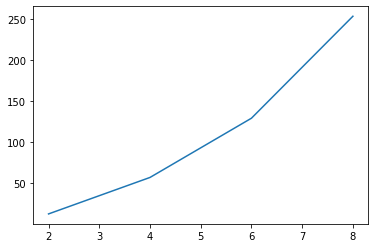

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(2,10,2),times)
plt.show()

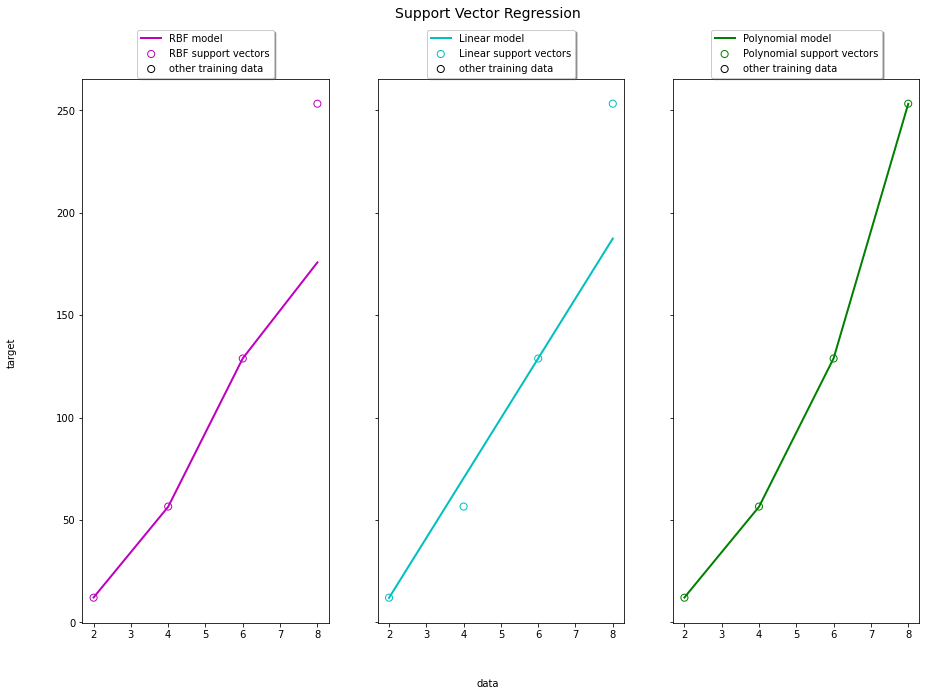

In [32]:
#Pre-built code from sklearn to determine the best regression for our plot.
from sklearn.svm import SVR
X = np.array(range(2,10,2)).reshape(-1,1)
y = np.array(times)
lw = 2

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)


svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [90]:
# Sklearn code to make a regression on polynomial parameters
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(np.array(range(2,9,2)).reshape(-1,1))
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly,times)

lin_reg_2.coef_

array([0.        , 0.48653851, 0.39263417])

In [91]:
#Scoring the regression
lin_reg_2.score(X_poly,times)

0.9939808526331017

In [14]:
def compute_from_list(l,x):
    #Computes the evaluation of a polynom for x with the list of coefficient in this order : 
    #If l = [a,b,c] then compute_from_list will output a+bx+cx^2
    return sum([x**index*l[index] for index,i in enumerate(l)])

def regandplot(index,values):
    #Plots the approximated polynom and the true points for a range of polynom degree
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    reg_coeff_list = []
    fig,axs = plt.subplots(10,2)
    for i in index:
        poly_reg = PolynomialFeatures(degree = i)
        X_poly = poly_reg.fit_transform(np.array(range(1,20)).reshape(-1,1))
        lin_reg_2 = LinearRegression()
        lin_reg_2.fit(X_poly,times)
        reg_coeff_list.append(lin_reg_2.coef_)
        l =  list(range(1,20))
        y = [compute_from_list(lin_reg_2.coef_,i) for i in l]
        b = int(i/2)
        axs[b,i%2].plot(l,y)
        axs[b,i%2].plot(l,times)
        axs[b,i%2].set_title("Regression with degree = "+str(i)+" score = "+str(round(lin_reg_2.score(X_poly,times),4)))
        axs[b,i%2].set_xlabel("Amount of data")
        axs[b,i%2].set_ylabel("Time to execute QSVM (in seconds)")
    fig.tight_layout()
    plt.show()
    return(reg_coeff_list)

QSVM with 50 features :  0.2794200961788491 hours
QSVM with 784 features :  0.007664776557696028 years


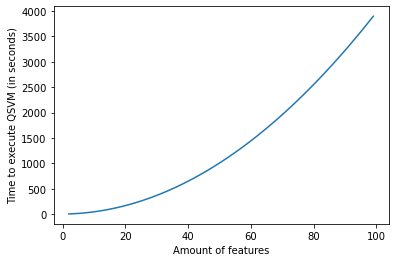

In [92]:
#Plotting the predictions of the regression
l =  list(range(2,100))

plt.plot(l,[compute_from_list(lin_reg_2.coef_,i) for i in l])
plt.xlabel("Amount of features")
plt.ylabel("Time to execute QSVM (in seconds)")

print("QSVM with 50 features : ",compute_from_list(lin_reg_2.coef_,50)/3600, "hours")
print("QSVM with 784 features : ",compute_from_list(lin_reg_2.coef_,784)/3600/24/365, "years")

 # Stress test on a noisy simulator over the amount of data

In [83]:
#Same process as before, but with the amount of data, showing the O(M^4.64), M the amount of data
#I dont recommend running this cell either (pretty long)
from utils import *
from qiskit.providers.aer.noise import NoiseModel

times = []
scores = []
backend = AerSimulator(method = "automatic")
backend_noise = provider.get_backend('ibm_wellington')
noise_model = NoiseModel.from_backend(backend_noise)
qinst = QuantumInstance(backend, noise_model=noise_model)
n_features = 2
for n_images in range(1,20):
    print("Executing with n_images = ",n_images)
    train_data_image,train_label_image = import_full_image(howmuch = n_images)
    pca = PCA(n_components=n_features)
    train_data_image = pca.fit_transform(train_data_image)
    image_feature_map = PauliFeatureMap(feature_dimension=n_features)
    kernel = QuantumKernel(feature_map = image_feature_map, quantum_instance=qinst)
    qsvc = QSVC(quantum_kernel=kernel, max_iter = 100)
    start = time.time()
    qsvc.fit(train_data_image,train_label_image)
    end = time.time()
    test_data_image, test_label_image = import_full_image(howmuch=10, imtype = "Testing")
    test_data_image = pca.fit_transform(test_data_image)
    s = qsvc.score(test_data_image,test_label_image)
    times.append(end-start)
    scores.append(s)

Executing with n_images =  1
Executing with n_images =  2
Executing with n_images =  3
Executing with n_images =  4
Executing with n_images =  5
Executing with n_images =  6
Executing with n_images =  7
Executing with n_images =  8
Executing with n_images =  9
Executing with n_images =  10
Executing with n_images =  11
Executing with n_images =  12
Executing with n_images =  13
Executing with n_images =  14
Executing with n_images =  15
Executing with n_images =  16
Executing with n_images =  17
Executing with n_images =  18
Executing with n_images =  19


In [84]:
times

[1.448258399963379,
 7.956230401992798,
 12.344536066055298,
 21.835230350494385,
 32.138893127441406,
 50.37065768241882,
 108.30114793777466,
 113.9055700302124,
 119.90266585350037,
 153.59237480163574,
 210.67430353164673,
 249.1786231994629,
 311.9426281452179,
 346.3996813297272,
 446.7085633277893,
 452.684121131897,
 905.6569464206696,
 456.0444357395172,
 519.6278612613678]

In [85]:
scores

[0.09,
 0.11,
 0.16,
 0.13,
 0.15,
 0.07,
 0.09,
 0.17,
 0.11,
 0.16,
 0.09,
 0.14,
 0.08,
 0.07,
 0.1,
 0.13,
 0.1,
 0.09,
 0.11]

In [87]:
#Saving it as well
np.save("times qsvc data size noisy simulator.npy", times)
np.save("scores qsvc data size noisy simulator.npy",scores)

In [2]:
times = np.load("times qsvc data size.npy")
scores = np.load("scores qsvc data size.npy")

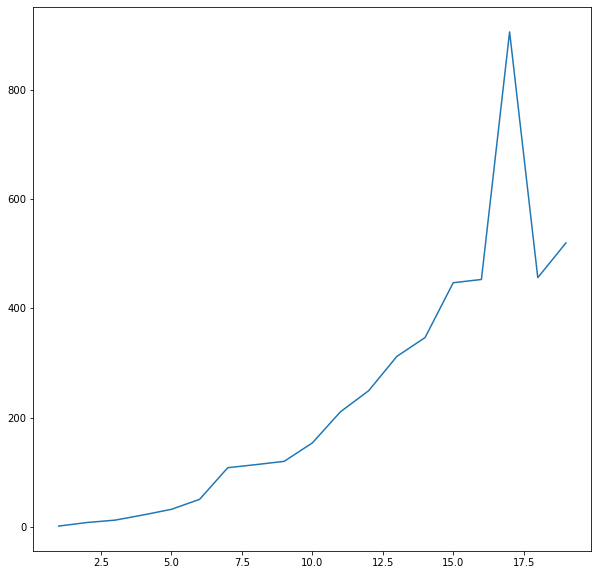

In [89]:
import matplotlib.pyplot as plt
plt.plot(range(1,20),times)

In [ ]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(np.array(range(2,9,2)).reshape(-1,1))
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly,times)

lin_reg_2.coef_

[2.0771985090140324, 6.8866122672052414, 14.428241274573628, 24.70208553111919, 37.708145036841934, 53.44641979174185, 71.91690979581894, 93.11961504907322, 117.05453555150467]
QSVM with 50 data :  0.9585621126924287 hours
QSVM with 1000 data :  15.81966105871544 days


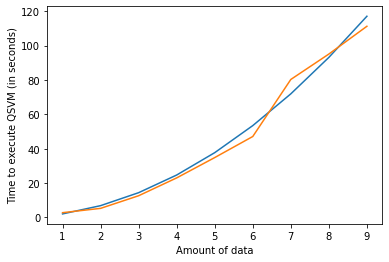

In [40]:
l =  list(range(1,10))
y = [compute_from_list(lin_reg_2.coef_,i) for i in l]
print(y)

plt.plot(l,y)
plt.plot(l,times)
plt.xlabel("Amount of data")
plt.ylabel("Time to execute QSVM (in seconds)")

print("QSVM with 50 data : ",compute_from_list(lin_reg_2.coef_,50)/3600, "hours")
print("QSVM with 1000 data : ",compute_from_list(lin_reg_2.coef_,1000)/3600/24, "days")

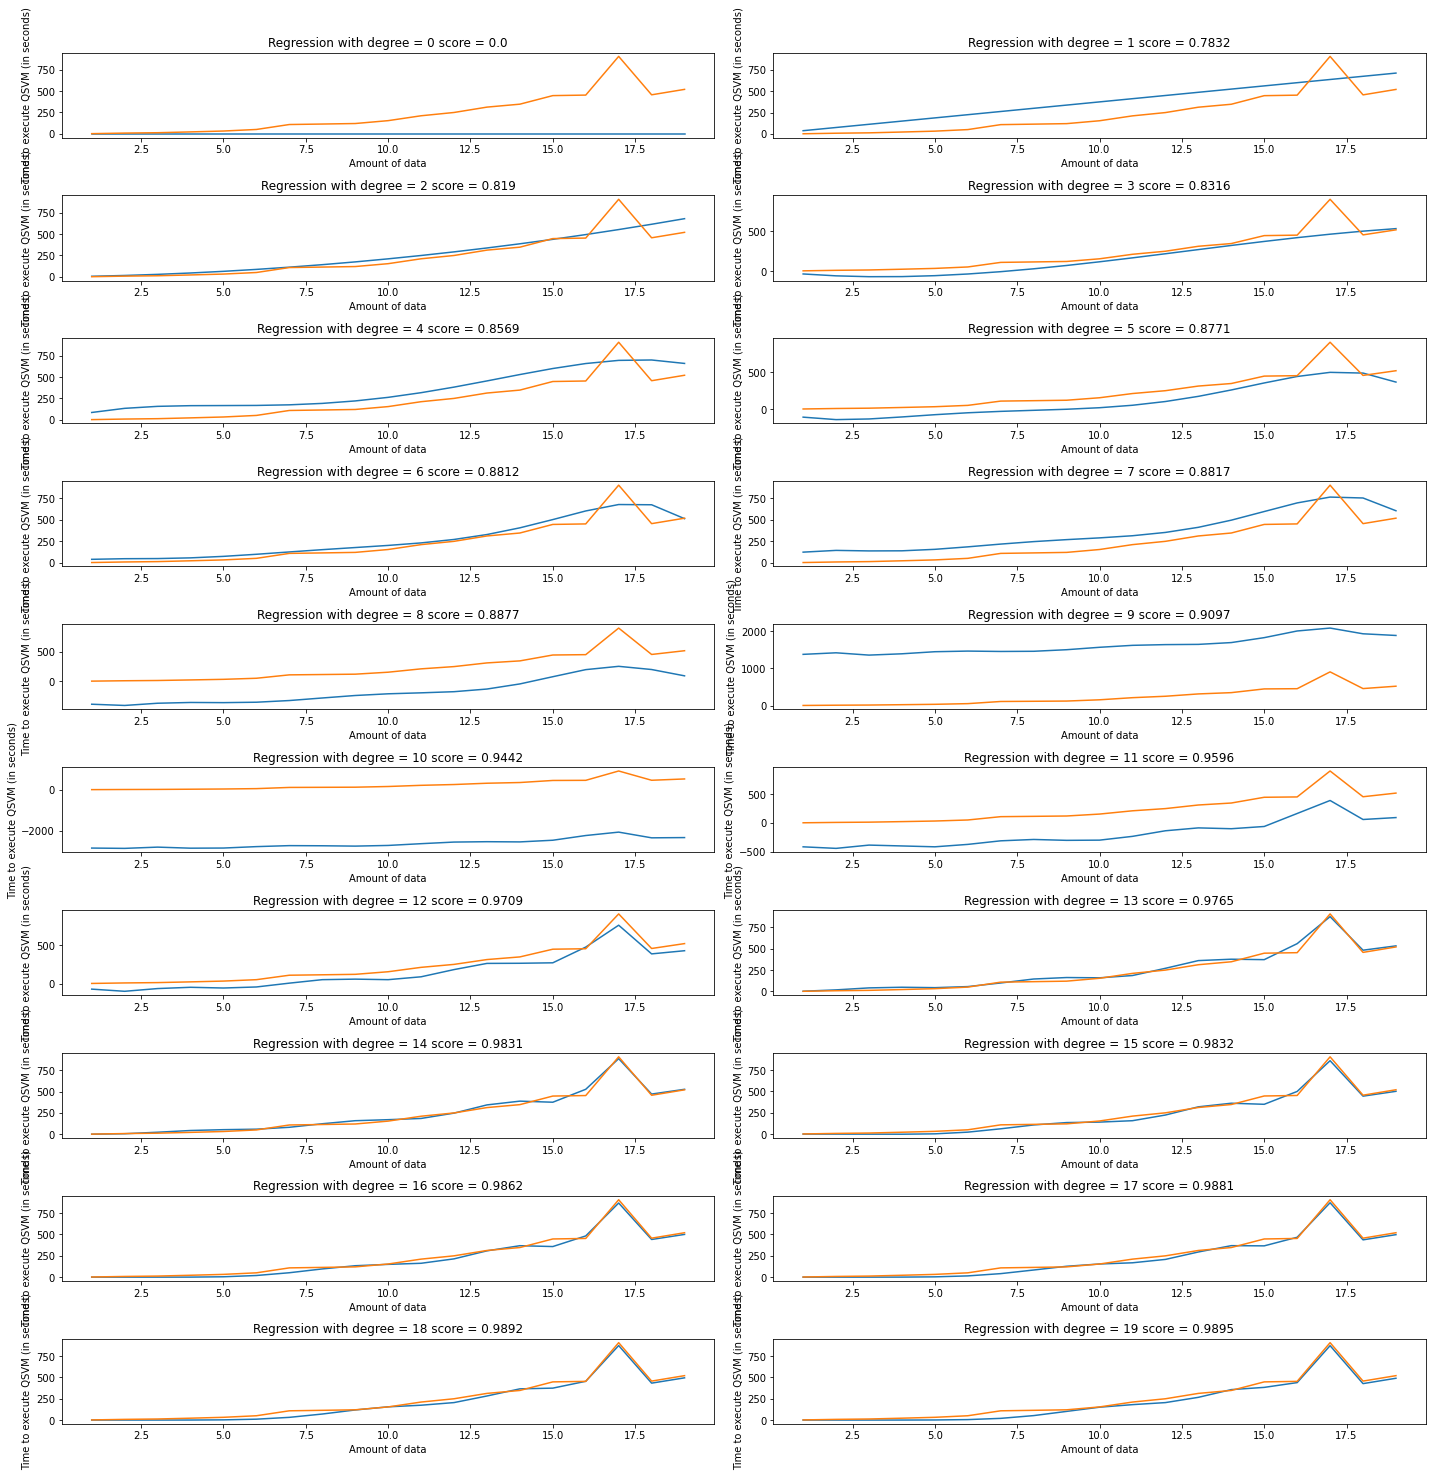

In [96]:
#Test the regression parameter
fig,axs = plt.subplots(10,2)
for i in range(0,20):
    poly_reg = PolynomialFeatures(degree = i)
    X_poly = poly_reg.fit_transform(np.array(range(1,20)).reshape(-1,1))
    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly,times)
    l =  list(range(1,20))
    y = [compute_from_list(lin_reg_2.coef_,i) for i in l]
    b = int(i/2)
    axs[b,i%2].plot(l,y)
    axs[b,i%2].plot(l,times)
    axs[b,i%2].set_title("Regression with degree = "+str(i)+" score = "+str(round(lin_reg_2.score(X_poly,times),4)))
    axs[b,i%2].set_xlabel("Amount of data")
    axs[b,i%2].set_ylabel("Time to execute QSVM (in seconds)")
fig.tight_layout()
plt.show()

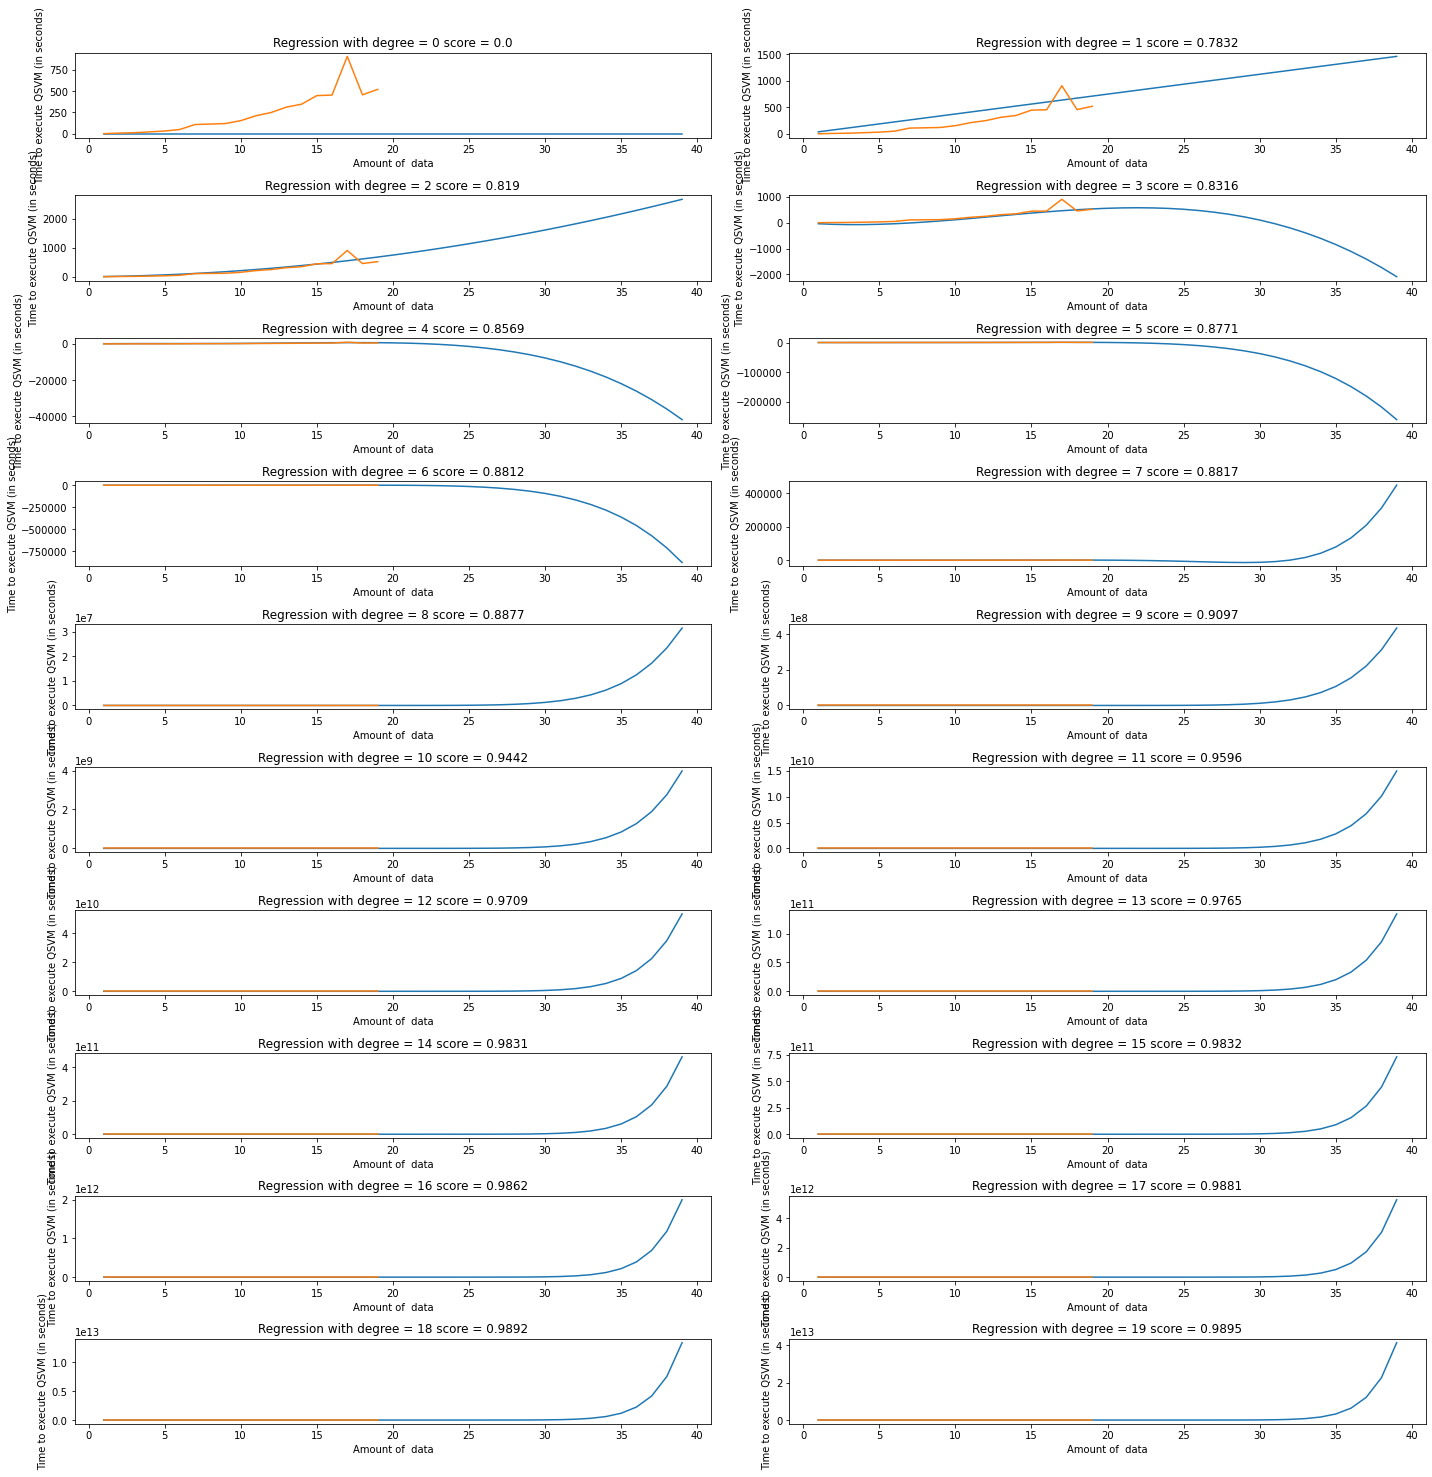

In [99]:
#Overfitting test
fig,axs = plt.subplots(10,2)
for i in range(0,20):
    poly_reg = PolynomialFeatures(degree = i)
    X_poly = poly_reg.fit_transform(np.array(range(1,20)).reshape(-1,1))
    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly,times)
    l =  list(range(1,40))
    y = [compute_from_list(lin_reg_2.coef_,a) for a in l]
    b = int(i/2)
    axs[b,i%2].plot(l,y)
    axs[b,i%2].plot(l[0:19],times)
    axs[b,i%2].set_title("Regression with degree = "+str(i)+" score = "+str(round(lin_reg_2.score(X_poly,times),4)))
    axs[b,i%2].set_xlabel("Amount of  data")
    axs[b,i%2].set_ylabel("Time to execute QSVM (in seconds)")
fig.tight_layout()
plt.show()

# Stress test on mock backend 

In [100]:
#Same test as before, but with a mock backend to simulate noise, gate disposition, ...
from utils import *
from qiskit.providers.aer.noise import NoiseModel

times = []
scores = []

backend_noise = provider.get_backend('ibm_wellington')
backend = AerSimulator.from_backend(backend_noise)
qinst = QuantumInstance(backend)
n_features = 2
for n_images in range(1,20):
    print("Executing with n_images = ",n_images)
    train_data_image,train_label_image = import_full_image(howmuch = n_images)
    pca = PCA(n_components=n_features)
    train_data_image = pca.fit_transform(train_data_image)
    image_feature_map = PauliFeatureMap(feature_dimension=n_features)
    kernel = QuantumKernel(feature_map = image_feature_map, quantum_instance=qinst)
    qsvc = QSVC(quantum_kernel=kernel, max_iter = 100)
    start = time.time()
    qsvc.fit(train_data_image,train_label_image)
    end = time.time()
    test_data_image, test_label_image = import_full_image(howmuch=10, imtype = "Testing")
    test_data_image = pca.fit_transform(test_data_image)
    s = qsvc.score(test_data_image,test_label_image)
    times.append(end-start)
    scores.append(s)

Executing with n_images =  1
Executing with n_images =  2
Executing with n_images =  3
Executing with n_images =  4
Executing with n_images =  5
Executing with n_images =  6
Executing with n_images =  7
Executing with n_images =  8
Executing with n_images =  9
Executing with n_images =  10
Executing with n_images =  11
Executing with n_images =  12
Executing with n_images =  13
Executing with n_images =  14
Executing with n_images =  15
Executing with n_images =  16
Executing with n_images =  17
Executing with n_images =  18
Executing with n_images =  19


In [101]:
times

[1.2302172183990479,
 4.159038305282593,
 11.260552644729614,
 21.447873830795288,
 32.90935015678406,
 51.17885184288025,
 71.71622633934021,
 93.46295666694641,
 119.5305564403534,
 157.99074816703796,
 191.28149461746216,
 220.64039397239685,
 256.9115903377533,
 314.2676043510437,
 342.67347145080566,
 390.98260474205017,
 448.9887933731079,
 496.8347566127777,
 559.9404399394989]

In [102]:
np.save("times qsvc data size fake backend.npy", times)
np.save("scores qsvc data size fake backend.npy",scores)

In [2]:
times = np.load("times qsvc data size fake backend.npy")
scores = np.load("scores qsvc data size fake backend.npy")

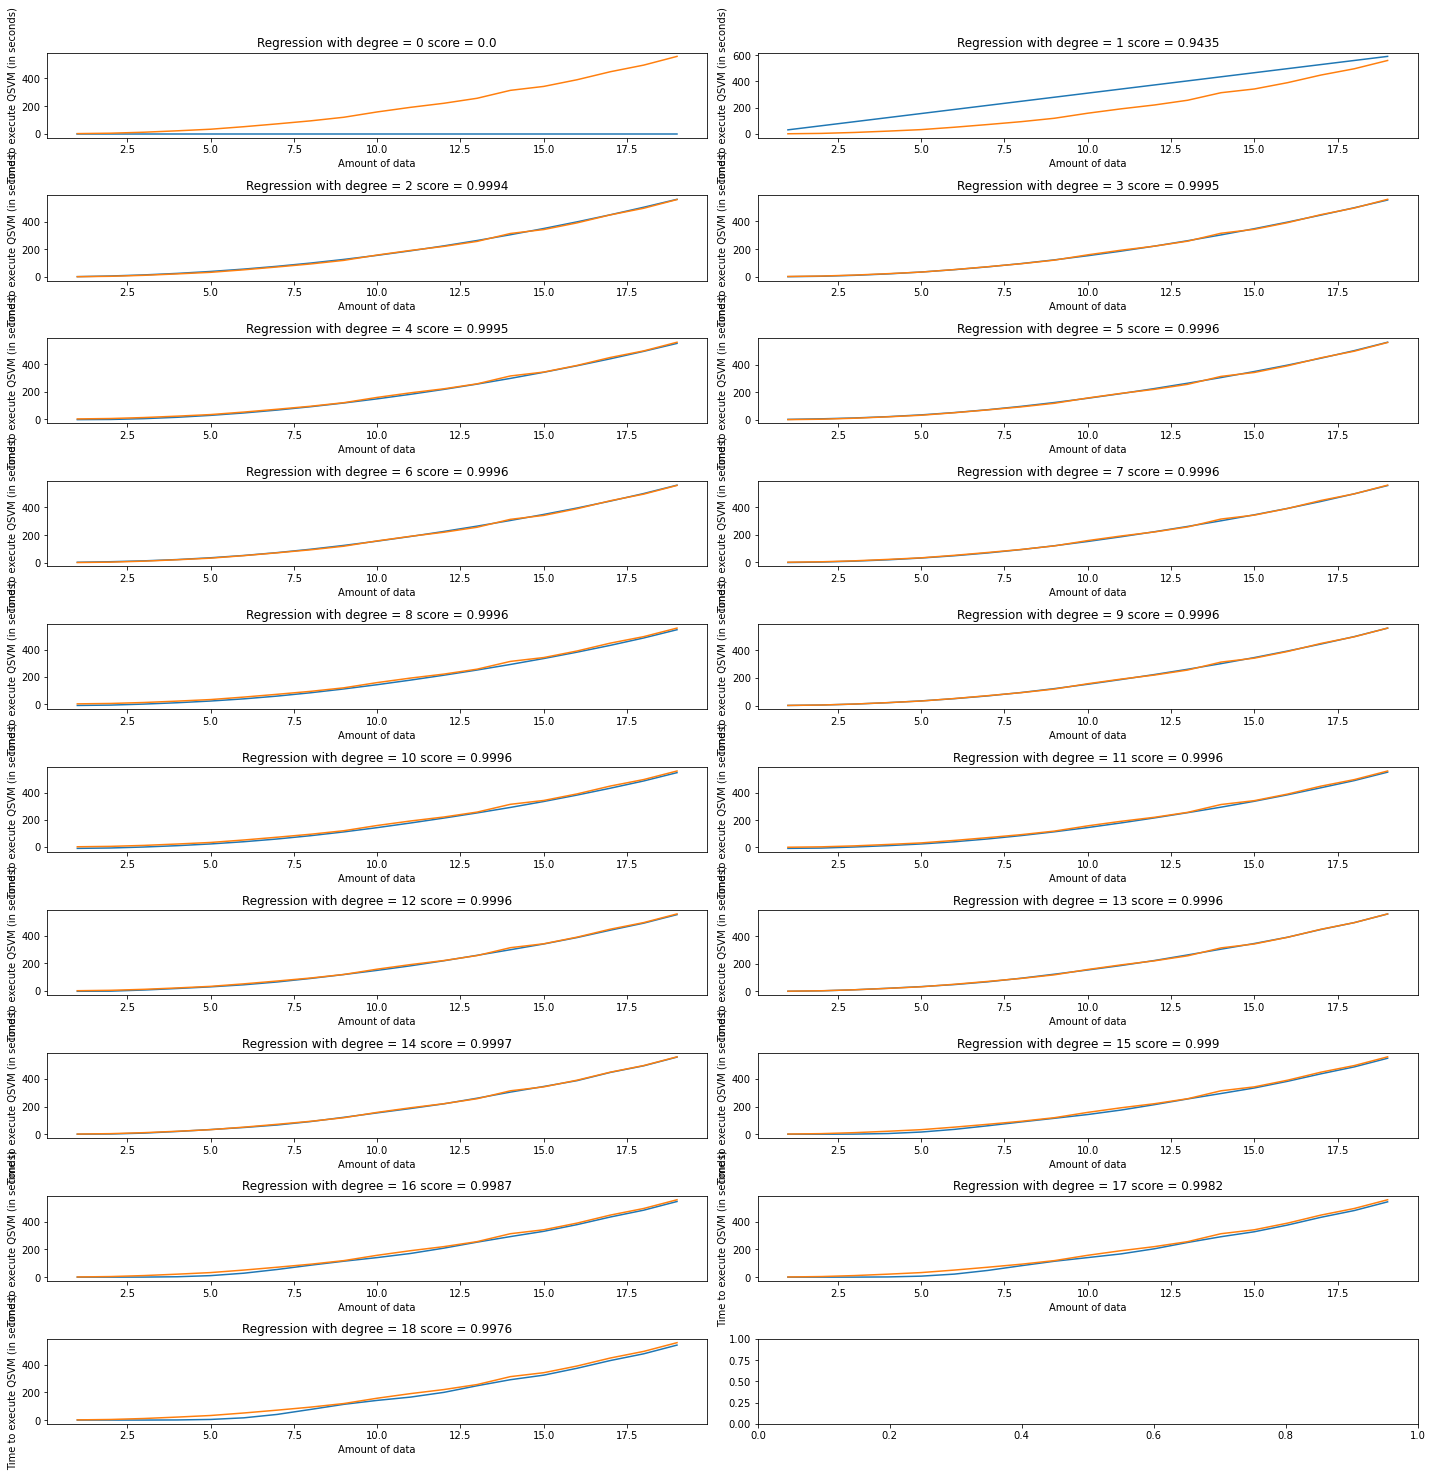

In [15]:
reg_list = regandplot(range(len(times)),times)

Training with 50 images :  13.238265154123013  hours
Training with 1000 images :  12.657565850483708  centuries


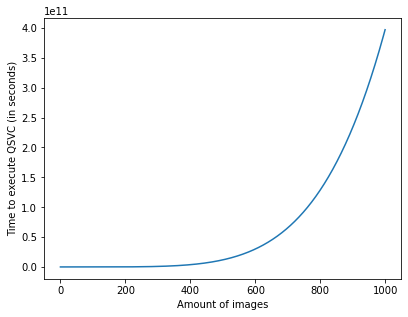

In [84]:
index = range(0,1000)
y = [compute_from_list(reg_list[5],i) for i in index]
plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.plot(index,y)
plt.xlabel("Amount of images")
plt.ylabel("Time to execute QSVC (in seconds)")
plt.rcParams['figure.figsize'] = [20, 20]
print("Training with 50 images : ",compute_from_list(reg_list[5],50)/3600 ," hours")
print("Training with 1000 images : ",compute_from_list(reg_list[5],1000)/3600/24/365/1000," centuries")

# Runtime stress test images

In [81]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(group = 'open')
backend = provider.get_backend('ibmq_belem')

ibmqfactory.load_account:WARNING:2022-07-25 11:32:07,188: Credentials are already in use. The existing account in the session will be replaced.


In [78]:
import os
#These programms are also available on the github, though as demonstrated before, you cant run those with much images
program_json = os.path.join(os.getcwd(),"qsvcbenchmarkimages.json")
program_data = os.path.join(os.getcwd(),"qsvcbenchmarkimages.py")

In [63]:
program_id = provider.runtime.upload_program(
                                            data = program_data,
                                            metadata = program_json)

In [65]:
print(program_id)
#qsvcruntimebenchmarkimages-MYGDyVZGZw
print(provider.runtime.program(program_id))


qsvcruntimebenchmarkimages-MYGDyVZGZw
qsvcruntimebenchmarkimages-MYGDyVZGZw:
  Name: qsvcruntimebenchmarkimages
  Description: Runtime with feature map evaluation, benchmark over the amount of images
  Creation date: 2022-07-25T08:29:23.698177Z
  Update date: 2022-07-25T08:29:23.698177Z
  Max execution time: 28800
  Input parameters:
    Properties:
        - max_iter_qsvc:
            Description: Max iter parameter of QSVC
            Type: int
            Required: True
        - test_data:
            Description: List of test data
            Type: list
            Required: True
        - test_label:
            Description: List of test labels, in one hot vector form
            Type: list
            Required: True
        - train_data:
            Description: List of train data
            Type: list
            Required: True
        - train_label:
            Description: List of train labels, in one hot vector form
            Type: list
            Required: True
  Interi

In [82]:
def interim_result(job_id,interim_result):
    #Just printing the dictionnary result
    print(interim_result)

In [85]:
train_data_image, train_label_image = import_full_image(howmuch = 1)
test_data_image, test_label_image = import_full_image(howmuch = 3, imtype = "Testing")


program_inputs = {'train_data':train_data_image,'train_label':train_label_image,'test_data':test_data_image,'test_label':test_label_image,"max_iter_qsvc" : 100}
options = {'backend_name':backend.name()}
job = provider.runtime.run(program_id=program_id,
                          options = options,
                          inputs = program_inputs,
                          callback = interim_result)
result = job.result()
#Training the model with one image took 55 seconds already

{'s': 'Started iterations for 10 images'}
{'s': 'Ended iterations for 10 images'}
{'time': 55.16361403465271, 'score': 0.16666666666666666}


In [75]:
from qiskit.tools.jupyter import job_watcher
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [80]:
#Cell to update the programs
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q-internal',group = 'support',project='core-team')
backend = provider.get_backend('ibmq_qasm_simulator')
program_id = "qsvcruntimebenchmarkimages-MYGDyVZGZw"
provider.runtime.update_program(program_id= program_id,data = program_data,metadata=program_json)

# User defined kernel (did not worked)
Lets try to make a homemade kernel : 3 rotations in each directions (each parametrised) for a total of $3q$ feature ($q$ being the amount of qubits)

In [6]:
def custom_kernel(feature_dimension, qubit_goal):
    #Create the custom kernel with the amount of feature you want to encode.
    #The qubit_goal argument will help the function determine how much repetitions of the gates it will have to apply
    num_qubits = int(feature_dimension/4)
    ancillas = 0
    reps_per_iteration = 1
    if(num_qubits > qubit_goal):
        #reduce the amount of qubits
        feature_left = feature_dimension - num_qubits*4
        reps_per_iteration = int(feature_left%num_qubits/4)+1
        num_qubits = qubit_goal
    else:
        print("Feature map only needs ",num_qubits," to work properly, returning a circuit with ",qubit_goal-num_qubits," ancillas")
        ancillas = qubit_goal-num_qubits
            
    feature_map = QuantumCircuit(num_qubits+ancillas)
    user_params = ParameterVector("θ", feature_dimension)
    for i in range(0,feature_dimension,4):
        for j in range(reps_per_iteration):
            feature_map.rx(user_params[(i+j)%feature_dimension],feature_map.qubits[i%num_qubits])
            feature_map.ry(user_params[(i+j+1)%feature_dimension],feature_map.qubits[i%num_qubits])
            feature_map.rz(user_params[(i+j+2)%feature_dimension],feature_map.qubits[i%num_qubits])
            feature_map.p(user_params[(i+j+3)%feature_dimension],feature_map.qubits[i%num_qubits])
            feature_map.cz(feature_map.qubits[(i+j)%num_qubits],feature_map.qubits[(i+j+1)%num_qubits])
    return feature_map

import time
start = time.time()
k = custom_kernel(10,2)
stop = time.time()
print("Kernel generated in ",stop-start)
print("Ops : ",k.count_ops())
print("Depth : ",k.depth())
print("Num_qubits ", k.num_qubits)


Feature map only needs  2  to work properly, returning a circuit with  0  ancillas
Kernel generated in  0.0020568370819091797
Ops :  OrderedDict([('rx', 3), ('ry', 3), ('rz', 3), ('p', 3), ('cz', 3)])
Depth :  15
Num_qubits  2


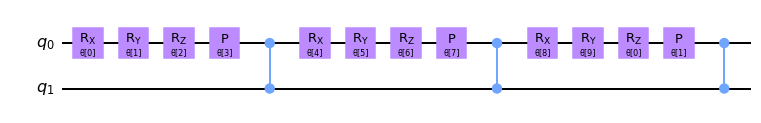

In [7]:
k.draw(output = 'mpl')

In [6]:
train_data_image, train_label_image = import_full_image(howmuch=15)
qinst = QuantumInstance(backend=Aer.get_backend('qasm_simulator'))
qkernel = QuantumKernel(feature_map=k, quantum_instance=qinst)
qsvc_custom = QSVC(quantum_kernel=qkernel)
qsvc_custom.fit(train_data_image,train_label_image)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002936BE26220>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [7]:
test_data_image,test_label_image = import_full_image(howmuch=5, imtype="Testing")
print("Training score : ",qsvc_custom.score(train_data_image,train_label_image))
print("Testing score : ",qsvc_custom.score(test_data_image,test_label_image))

Training score :  1.0
Testing score :  0.08


Bugged
<a id="bugged"></a>


In [10]:
#This is very bugged !
test_data_image2,test_label_image2 = import_full_image(howmuch=15, imtype="Testing")
print("Testing score : ",qsvc_custom.score(test_data_image2,test_label_image2))

Testing score :  1.0


In [11]:
test, test_label = import_full_image(howmuch = 100, imtype = "Testing")

In [13]:
number = 3
ind = 50*number
start = time.time()
print("Pred : ",qsvc_custom.predict(test[ind]))
print("Truth : ",test_label[ind])
end = time.time()
print("Time taken : ",end-start)

Pred :  [9]
Truth :  1
Time taken :  57.746084690093994


# Using Quantum kernel trainer to avoid the polynomial scaling of qsvc
(transferring it to the quantumkerneltrainer function)

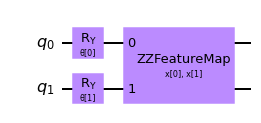

In [17]:
#With adhoc data
user_params = ParameterVector("θ",2)
qc = QuantumCircuit(2)
qc.ry(user_params[0],0)
qc.ry(user_params[1],1)
qc = qc.compose(ZZFeatureMap(2))
qc.draw(output = 'mpl')

In [25]:
def callback(eva,param,value,stepsize,accept):
    #Dynamic graph to visualize the evolution of the score of the quantum kernel trainer
    #The core of this function is the clear_output function
    clear_output(wait = True)
    value_obj.append(value)
    plt.title("Objective function in SPSA")
    plt.xlabel("Iteration")
    plt.ylabel("Objective value")
    plt.plot(range(len(value_obj)),value_obj)
    plt.show()

In [19]:
#Creating the instance of the quantum kernel trainer
kernel = QuantumKernel(feature_map=qc,user_parameters=user_params,quantum_instance=backend)
optimizer = SPSA(callback=callback)
qkt = QuantumKernelTrainer(quantum_kernel=kernel, optimizer=optimizer, loss='svc_loss')

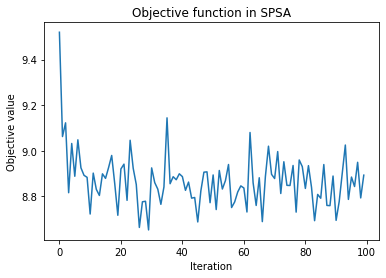

In [20]:
value_obj = []
qka_result = qkt.fit(train_data,train_labels_one)

In [21]:
#Extracting the optimized kernel
optimized_kernel = qka_result.quantum_kernel
print(qka_result)

{   'optimal_parameters': {   ParameterVectorElement(θ[1]): -0.20682137127897232,
                              ParameterVectorElement(θ[0]): -0.07137187323303837},
    'optimal_point': array([-0.07137187, -0.20682137]),
    'optimal_value': 8.780233314184976,
    'optimizer_evals': 300,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000026DF4F97940>}


In [22]:
#training qsvc on the trained kernel
qsvc = QSVC(quantum_kernel=optimized_kernel)
qsvc.fit(train_data,train_labels_one)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000026DF4F97940>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [23]:
print("Train score ",qsvc.score(train_data,train_labels_one))
print("Test score ",qsvc.score(test_data,test_labels_one))

Train score  1.0
Test score  1.0


# Using quantum kernel trainer with images

In [1]:
#Cell stopped, ran too long
num_qubit = 7
feature_kernel = QuantumCircuit(num_qubit)
user_parameters = ParameterVector('β',num_qubit)
for ind, param in enumerate(user_parameters):
    feature_kernel.ry(param,ind)
feature_kernel.append(custom_kernel(784,num_qubit), range(num_qubit))


train_data_image, train_label_image = import_full_image(howmuch=15)
qinst = QuantumInstance(backend=Aer.get_backend('qasm_simulator'))
qkernel = QuantumKernel(feature_map=feature_kernel, quantum_instance=qinst, user_parameters=user_parameters)
optimizer = SPSA(callback=callback)
qkt = QuantumKernelTrainer(quantum_kernel=qkernel,optimizer=optimizer,loss = 'svc_loss')
qktresult = qkt.fit(train_data_image,train_label_image)

NameError: name 'QuantumCircuit' is not defined

# Test with another feature reduction algorithm https://www.qmunity.tech/tutorials/building-a-variational-quantum-classifier (the result of this link are linked to the same bug as [here](#bugged))

In [2]:
import tensorflow as tf
(train_data, train_label),(test_data,test_label) = tf.keras.datasets.mnist.load_data()
train_data = np.array([i.reshape(28*28) for i in train_data])
test_data = np.array([i.reshape(28*28) for i in test_data])
print(train_data.shape)
image_size = 28

(60000, 784)


In [3]:
train_data_features = train_data[:10]
train_data_labels = train_label[:10]
test_data_features = test_data[:100]
test_data_labels = test_label[:100]

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [6]:
#Using truncateSVD and TNSE to perform feature reduction
tsvd = TruncatedSVD(n_components=10)
train_data_svd = tsvd.fit_transform(train_data_features)
test_data_svd = tsvd.fit_transform(test_data_features)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(train_data_svd)
test_data_features_reduced = tsne.fit_transform(test_data_svd)
train_data_features_reduced.shape

C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(10, 2)

In [13]:
train_data_labels

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [14]:
qinst = QuantumInstance(backend=AerSimulator())
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
kernel = QuantumKernel(feature_map = feature_map, quantum_instance=qinst)
qsvc = QSVC(quantum_kernel=kernel, verbose = True)
qsvc.fit(train_data_features_reduced,train_data_labels)
qsvc.score(train_data_features_reduced,train_data_labels)

[LibSVM]

0.6

In [15]:
qsvc.score(test_data_features_reduced,test_data_labels)

0.16

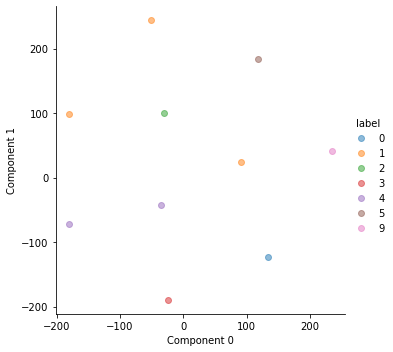

In [20]:
# function to help plot the 2-D dataset
import seaborn as sns
import pandas as pd
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

# Feature reduction may work


In [21]:
import tensorflow as tf
(train_data, train_label),(test_data,test_label) = tf.keras.datasets.mnist.load_data()
train_data = np.array([i.reshape(28*28) for i in train_data])
test_data = np.array([i.reshape(28*28) for i in test_data])
image_size = 28

train_size = 200
test_size = 100

train_data_features = train_data[:train_size]
train_data_labels = train_label[:train_size]
test_data_features = test_data[:test_size]
test_data_labels = test_label[:test_size]
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
tsvd = TruncatedSVD(n_components=10)
train_data_svd = tsvd.fit_transform(train_data_features)
test_data_svd = tsvd.fit_transform(test_data_features)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(train_data_svd)
test_data_features_reduced = tsne.fit_transform(test_data_svd)
train_data_features_reduced.shape

C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\108997706\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(200, 2)

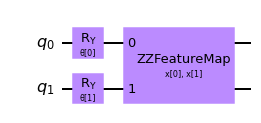

In [22]:
#With adhoc data
user_params = ParameterVector("θ",2)
qc = QuantumCircuit(2)
qc.ry(user_params[0],0)
qc.ry(user_params[1],1)
qc = qc.compose(ZZFeatureMap(2))
qc.draw(output = 'mpl')

In [26]:
backend = AerSimulator()
kernel = QuantumKernel(feature_map=qc,user_parameters=user_params,quantum_instance=backend)
optimizer = SPSA(callback=callback)
qkt = QuantumKernelTrainer(quantum_kernel=kernel, optimizer=optimizer, loss='svc_loss')

In [27]:
#Stopped, ran too long
value_obj = []
qka_result = qkt.fit(train_data_features_reduced,train_data_labels)

KeyboardInterrupt: 

In [ ]:
optimized_kernel = qka_result.quantum_kernel
print(qka_result)

In [ ]:
qsvc = QSVC(quantum_kernel=optimized_kernel)
qsvc.fit(train_data_features_reduced,train_data_labels)

In [ ]:
qsvc.score(train_data_features_reduced,train_data_labels)

In [ ]:
qsvc.score(test_data_features_reduced,test_data_labels)

# Custom pauli feature map

In [2]:
train_data_image,train_label_image = import_full_image(howmuch = 5)
pca = PCA(n_components=2)
train_data_image = pca.fit_transform(train_data_image)

In [33]:
def modify_pauli(circ, pv):
    #Function to modify the pauli feature map to add a parameter α from a ParameterVector in the parameters of each pauli gates
    #This function takes the pauli feature map on which you called decompose.
    #It is adviced to set the alpha parameter of Qiskit's PauliFeatureMap to 1 before calling this function to avoid having a weird constant
    import copy
    from qiskit.circuit.exceptions import CircuitError
    from qiskit.circuit.parametertable import ParameterReferences
    from qiskit.circuit import ParameterExpression
    from sympy import Mul,Symbol
    import warnings
    len_circ = len(circ)
    p_gates = [i for i in range(len_circ) if circ[i][0].name == 'p']
    if len_circ < len(pv):
        raise CircuitError("The amount of parameters in the parameter vector should not be greater than the amount of gates in the circuit. Also check that the feature map you input as been called decompose on.")
    if len(p_gates) < len(pv):
        warnings.warn("Too much Parameters has been given, only the first "+str(len(p_gates))+" will be used",UserWarning)
    next_p = 0
    for index,i in enumerate(p_gates):
        old = copy.deepcopy(circ[i][0].params[0])
        new_expr = Mul(Symbol(pv[index].name), old.sympify())
        param_const = {pv[index] : pv[index].name}
        for param in old.parameters:
            param_const[param] = param.name
        Pe = ParameterExpression(param_const,new_expr)
        circ[i][0].params[0] = Pe
        circ._parameter_table[pv[index]] = ParameterReferences([(circ[i].operation,0)])

In [4]:
user_params = ParameterVector("α",6)
qc = PauliFeatureMap(2, alpha = 1).decompose()
modify_pauli(qc, user_params)
qc.draw()

┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ P(x[0]*α[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(x[1]*α[1]) ├┤ X ├┤ P(α[2]*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ P(x[0]*α[3]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ P(x[1]*α[4]) ├┤ X ├┤ P(α[5]*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘

In [5]:
from qiskit.circuit import Parameter
print(qc.parameters.data)
qc.assign_parameters({qc.parameters.data[0] : 1})

[ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(α[0]), ParameterVectorElement(α[1]), ParameterVectorElement(α[2]), ParameterVectorElement(α[3]), ParameterVectorElement(α[4]), ParameterVectorElement(α[5])]


In [6]:
def callback(eva,param,value,stepsize,accept):
    clear_output(wait = True)
    value_obj.append(value)
    plt.title("Objective function in SPSA")
    plt.xlabel("Iteration")
    plt.ylabel("Objective value")
    plt.plot(range(len(value_obj)),value_obj)
    plt.show()

In [7]:
backend = AerSimulator(method = 'automatic')
kernel = QuantumKernel(feature_map=qc,user_parameters=user_params,quantum_instance=backend)
optimizer = SPSA(callback=callback)
qkt = QuantumKernelTrainer(quantum_kernel=kernel, optimizer=optimizer, loss='svc_loss')

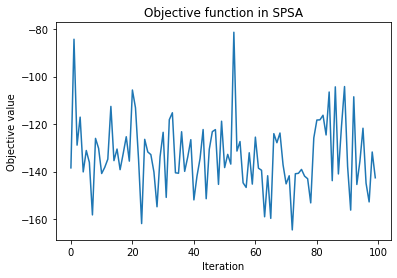

In [9]:
value_obj = []
qka_result = qkt.fit(train_data_image,train_label_image)

In [10]:
qka_result

In [11]:
optimized_kernel = qka_result.quantum_kernel

In [14]:
qsvc = QSVC(quantum_kernel=optimized_kernel)
qsvc.fit(train_data_image,train_label_image)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000272FDA15430>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [16]:
test_data_image,test_label_image = import_full_image(howmuch = 10, imtype="Testing")
test_data_image = pca.fit_transform(test_data_image)
qsvc.score(test_data_image, test_label_image)

0.11

In [17]:
qsvc.score(train_data_image,train_label_image)

0.6

The testing score did not went up.

# QSVC benchmark on runtime
This test does not work as I discovered later that QSVC is heavily noise sensitive

In [2]:
from utils import *
train_data, train_labels = import_full_image(howmuch=10)
test_data, test_labels = import_full_image(howmuch=10, imtype="Testing")

In [3]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='support', project='core-team')

In [17]:
import os
program_json = os.path.join(os.getcwd(),"qsvcbenchmarkruntime.json")
program_data = os.path.join(os.getcwd(),"qsvcbenchmarkruntime.py")

In [8]:
program_id = provider.runtime.upload_program(
                                            data = program_data,
                                            metadata = program_json)
#id : qsvcruntime-EjDpeWAoMj
print("Programm id : ",program_id)
print(provider.runtime.program(program_id))

Programm id :  qsvcruntime-EjDpeWAoMj
qsvcruntime-EjDpeWAoMj:
  Name: qsvcruntime
  Description: Runtime with feature map evaluation, benchmark over the amount of features, maxed out by the amount of qubits.
  Creation date: 2022-07-15T07:56:40.25422Z
  Update date: 2022-07-15T07:56:40.25422Z
  Max execution time: 28800
  Input parameters:
    Properties:
        - max_features:
            Description: Maximum amount of features the benchmark will be run with. The amount of features start at 2 and evolves 2 by 2.
            Type: int
            Required: True
        - test_data:
            Description: List of test data
            Type: list
            Required: True
        - test_label:
            Description: List of test labels, in one hot vector form
            Type: list
            Required: True
        - train_data:
            Description: List of train data
            Type: list
            Required: True
        - train_label:
            Description: List of trai

In [18]:
program_id = "qsvcruntime-EjDpeWAoMj"
provider.runtime.update_program(program_id= program_id,data = program_data,metadata=program_json)

In [19]:
backend = provider.get_backend("ibmq_qasm_simulator")

In [4]:
def interim_result(job_id,interim_result):
    print(interim_result["s"])
    

In [20]:
from qiskit.providers.aer.noise import NoiseModel
program_id = "qsvcruntime-EjDpeWAoMj"

backend_noise = provider.get_backend("ibm_wellington")
noise_model = NoiseModel.from_backend(backend_noise)



program_inputs = {'train_data':train_data,'train_label':train_labels,'test_data':test_data,'test_label':test_labels, 'max_features':6, 'max_iter_qsvc':-1, 'noise_model':noise_model}
options = {'backend_name':backend.name()}
job = provider.runtime.run(program_id=program_id,
                          options = options,
                          inputs = program_inputs,
                          callback=interim_result)
result = job.result()

TypeError: Object of type NoiseModel is not JSON serializable

# Easier dataset

In [3]:
#Importing the covid data in form of a dictionnary. The severity other than severe are removed
# And the country factor is removed as well to avoid having to encode it and avoid makinf our model
# too complicated
import pandas as pd
cov_dict = pd.read_csv('covid.csv').to_dict()
cov_dict.pop('Severity_Mild',None)
cov_dict.pop('Severity_Moderate',None)
cov_dict.pop('Severity_None',None)
cov_dict.pop('Country',None);
y = cov_dict.pop('Severity_Severe',None)
y_list = np.array(list(y.values()))
x = cov_dict
x.keys()

dict_keys(['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male', 'Gender_Transgender', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes'])

In [6]:
# We shuffle our data before training and extract the 20 best components (out of 22)
#Shuffling
import random
x_list = np.array([np.array([x.get(k)[i] for k in list(x.keys())]) for i in range(len(x.get('Fever')))])
enum = list(enumerate(x_list))
random.shuffle(enum)
index, _ = zip(*enum)
x_shuffle = x_list[index,:]
y_list = np.array(list(y.values()))
y_oh = encoder.fit_transform(y_list.reshape(-1, 1)).toarray()
y_oh_shuffle = y_oh[index,:]
y_shuffle = y_list[list(index)]
#Extracting
from sklearn.feature_selection import SelectKBest, chi2
select = SelectKBest(score_func=chi2, k=20)
x_shuffle = select.fit_transform(x_shuffle,y_oh_shuffle)

In [7]:
#Lets start by training using a portion of the dataset
train_data = x_shuffle[0:100]#100 training data
train_label = y_shuffle[0:100]
test_data = x_shuffle[100:200]#100 testing data
test_label = y_shuffle[100:200]

In [13]:
feature_map = EfficientSU2(num_qubits=2,reps =4, parameter_prefix='in')
qinst = QuantumInstance(backend = AerSimulator())
kernel = QuantumKernel(feature_map = feature_map, quantum_instance=qinst)
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_data,train_label)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000019D15F0E3A0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [14]:
print(qsvc.score(train_data,train_label))
print(qsvc.score(test_data,test_label))

0.71
0.75


### Comparison with the classical SVC

In [8]:
from sklearn.svm import SVC
clx = SVC()
clx.fit(train_data,train_label)

SVC()

In [9]:
print("Training", clx.score(train_data,train_label))
print("Test",clx.score(test_data,test_label))

Training 0.75
Test 0.63
